# Import Everything
## Import necessary modules

In [169]:

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xgboost as xgb

from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, f1_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.classifier import ConfusionMatrix

main_path = os.getcwd()
parent_path = Path(os.getcwd()).parent
src_path = str(parent_path) + "/src/directories"
os.chdir(src_path)

import change_directory

os.chdir(main_path)

## Import data

In [6]:
cd = change_directory.ChangeDirectory()
cd.change_to_data_dir()
ccd_df = pd.read_csv("processed/processed_credit_card_defaults.csv")
cd.change_to_notebook_dir()

,LIMIT_BAL,AGE,Bill_amount_Sep,Bill_amount_Aug,Bill_amount_Jul,Bill_amount_Jun,Bill_amount_May,Bill_amount_Apr,Bill_amount_Sep.1,Bill_amount_Aug.1,...,Payment_hist_Apr_-2,Payment_hist_Apr_-1,Payment_hist_Apr_0,Payment_hist_Apr_2,Payment_hist_Apr_3,Payment_hist_Apr_4,Payment_hist_Apr_5,Payment_hist_Apr_6,Payment_hist_Apr_7,Payment_hist_Apr_8
0,20000,24,3913,3102,689,0,0,0,0,689,...,1,0,0,0,0,0,0,0,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,0,0,0,1,0,0,0,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,0,0,1,0,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,0,0,1,0,0,0,0,0,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,0,0,1,0,0,0,0,0,0,0


## Extra Functions (Move to new file eventually)

In [229]:
def plot_confusion_matrix(model, X_train, X_test, y_train, y_test):
    model_cm = ConfusionMatrix(model)
    model_cm.fit(X_train, y_train)
    model_cm.score(X_test, y_test)
    model_cm.poof()

# Begin Model Building
## Train-Test Split

In [9]:
ccd_df.columns

Index(['LIMIT_BAL', 'AGE', 'Bill_amount_Sep', 'Bill_amount_Aug',
       'Bill_amount_Jul', 'Bill_amount_Jun', 'Bill_amount_May',
       'Bill_amount_Apr', 'Bill_amount_Sep.1', 'Bill_amount_Aug.1',
       'Bill_amount_Jul.1', 'Bill_amount_Jun.1', 'Bill_amount_May.1',
       'Bill_amount_Apr.1', 'DEFAULT', 'FEMALE', 'GRADUATE_SCHOOL',
       'UNIVERSITY', 'HIGH_SCHOOL', 'EDUCATION_OTHERS', 'EDUCATION_UNKNOWN_1',
       'EDUCATION_UNKNOWN_2', 'MARRIED', 'SINGLE', 'MARRIAGE_OTHERS',
       'Payment_history_Sept_-2', 'Payment_history_Sept_-1',
       'Payment_history_Sept_0', 'Payment_history_Sept_1',
       'Payment_history_Sept_2', 'Payment_history_Sept_3',
       'Payment_history_Sept_4', 'Payment_history_Sept_5',
       'Payment_history_Sept_6', 'Payment_history_Sept_7',
       'Payment_history_Sept_8', 'Payment_history_Aug_-2',
       'Payment_history_Aug_-1', 'Payment_history_Aug_0',
       'Payment_history_Aug_1', 'Payment_history_Aug_2',
       'Payment_history_Aug_3', 'Payment_hist

In [10]:
X = ccd_df.drop('DEFAULT', axis=1)
y = ccd_df.DEFAULT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2819)

## Decision Tree

In [175]:
ccd_dt = DecisionTreeClassifier()
class_weights_gs = [{0:100, 1:1}, 'balanced', {0:10, 1:1}]
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth':[None, 8, 10],
              'min_samples_split':[10, 25],
              'min_samples_leaf':[1, 5],
              'max_features':[None, 'sqrt'], 
              'class_weight':class_weights_gs }

dt_gs = GridSearchCV(ccd_dt, param_grid, cv=3, scoring='f1', refit=True)

In [176]:
dt_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None, 8, 10], 'min_samples_split': [10, 25], 'min_samples_leaf': [1, 5], 'max_features': [None, 'sqrt'], 'class_weight': [{0: 100, 1: 1}, 'balanced', {0: 10, 1: 1}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

### Evaluating the best tree

In [177]:
dt_gs.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 25}

In [182]:
best_tree = DecisionTreeClassifier(**dt_gs.best_params_)
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=8, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=25,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [183]:
y_preds_best_tree = best_tree.predict(X_test)
f1_score(y_test, y_preds_best_tree)

0.5122177544076709

### Confusion Matrix

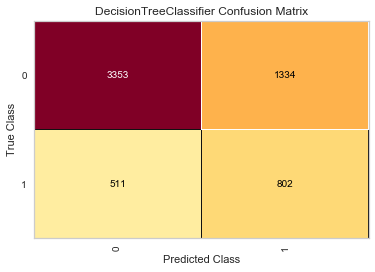

In [45]:
cm = ConfusionMatrix(best_tree, classes=[0, 1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

## Random Forest

### Random Forest with the same hyperparameters as the best decision tree

In [95]:
ccd_rf = RandomForestClassifier(n_estimators=100, **dt_gs.best_params_)

In [96]:
ccd_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=25, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [145]:
y_preds = ccd_rf.predict(X_test)
f1_score(y_test, y_preds)

0.5491773308957953

In [146]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_preds)
print(auc(fpr, tpr))

0.7144053223001314


### Random Forest GridSearch

In [132]:
ccd_rf_clf_gs = RandomForestClassifier(n_estimators=100)

In [133]:
ccd_rf_gs_params = {
    'class_weight':['balanced', {0:1, 1:100}, {0:1, 1:50}, {0:1, 1:75}],
    'min_samples_leaf':[15, 20, 25],
    'min_samples_split':[40, 50, 70]
}
ccd_rf_gs = GridSearchCV(ccd_rf_clf_gs, ccd_rf_gs_params, cv=3, scoring='f1', n_jobs=-1)

In [134]:
ccd_rf_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'class_weight': ['balanced', {0: 1, 1: 100}, {0: 1, 1: 50}, {0: 1, 1: 75}], 'min_samples_leaf': [15, 20, 25], 'min_samples_split': [40, 50, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [135]:
ccd_rf_gs.best_params_


{'class_weight': 'balanced', 'min_samples_leaf': 15, 'min_samples_split': 40}

In [136]:
ccd_rf_opt = RandomForestClassifier(**ccd_rf_gs.best_params_, n_estimators=100)

In [151]:
ccd_rf_opt.fit(X_train, y_train)
ccd_rf_opt_preds = ccd_rf_opt.predict(X_test)
print(f1_score(y_test, ccd_rf_opt_preds))
print(recall_score(y_test, ccd_rf_opt_preds))
roc_auc_score(y_test, ccd_rf_opt_preds)

0.5534591194968553
0.6031987814166032


0.7208441101450416

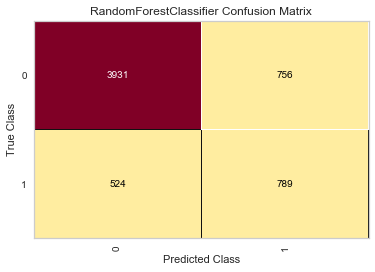

In [233]:
plot_confusion_matrix(ccd_rf_opt, X_train, X_test, y_train, y_test)

In [173]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, ccd_rf_opt.predict_proba(X_test)[:, 1])

## XGBoost

In [138]:
ccd_xgb = xgb.XGBClassifier(objective='binary:hinge')

In [139]:
xgb_gs_params = {
    'max_depth':[5, 6, 7, 8, 10]
}

xgb_gs = GridSearchCV(ccd_xgb, xgb_gs_params, scoring='f1', n_jobs=-1, cv=3)

In [140]:
xgb_gs.fit(X_train, y_train);

In [186]:
y_preds_xgb = xgb_gs.predict(X_test)
f1_score(y_test, y_preds_xgb)


0.4772170504654581

In [188]:
dtrain = xgb.DMatrix(X_train, label=np.array(y_train))
dtest = xgb.DMatrix(X_test, label=np.array(y_test))

In [155]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric':['error', 'auc'],
    'max_depth': 7
}

In [159]:
ccd_xgb = xgb.train(xgb_params, dtrain=dtrain, evals=[(dtest, 'Test')], num_boost_round=11)

[0]	Test-error:0.179333	Test-auc:0.76417
[1]	Test-error:0.179167	Test-auc:0.771551
[2]	Test-error:0.1785	Test-auc:0.775561
[3]	Test-error:0.176333	Test-auc:0.779066
[4]	Test-error:0.175833	Test-auc:0.781194
[5]	Test-error:0.176167	Test-auc:0.782922
[6]	Test-error:0.1775	Test-auc:0.783921
[7]	Test-error:0.176167	Test-auc:0.784484
[8]	Test-error:0.177167	Test-auc:0.784968
[9]	Test-error:0.178	Test-auc:0.78529
[10]	Test-error:0.178	Test-auc:0.786607


In [165]:
xgb_preds = (ccd_xgb.predict(dtest) >=0.5).astype(int)
f1_score(y_test, xgb_preds)

0.46865671641791046

In [171]:
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, ccd_xgb.predict(dtest))

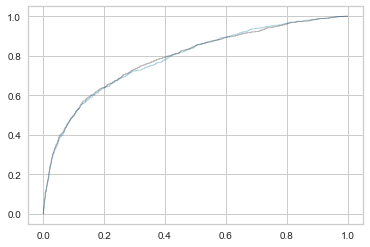

In [174]:
plt.plot(xgb_fpr, xgb_tpr, lw=1, alpha=0.3)
plt.plot(rf_fpr, rf_tpr, lw=1, alpha=0.3, color='k')

## Logistic Regression

In [197]:
ccd_lr = LogisticRegression(solver='liblinear', C=10)

In [198]:
ccd_lr.fit(X_train, y_train);

In [199]:
y_preds_lr = ccd_lr.predict(X_test)
recall_score(y_test, y_preds_lr)

0.0

In [200]:
ccd_lr.score(X_test, y_test)

0.781

# Upsampling, Downsampling, SMOTE

In [207]:
pos_samples = ccd_df[ccd_df.DEFAULT == 1]
neg_samples = ccd_df[ccd_df.DEFAULT == 0]

num_pos = pos_samples.shape[0]
num_neg = neg_samples.shape[0]

print(f"Number of defaults:{num_pos}")
print(f"Number of non-defaults: {num_neg}")

Number of defaults:6636
Number of non-defaults: 23364


## Upsampling

In [237]:
pos_samples_train, pos_samples_test = train_test_split(
    pos_samples, test_size=0.2)
neg_samples_train, neg_samples_test = train_test_split(
    neg_samples, test_size=0.2)

ups_pos_idx = np.random.choice(
    pos_samples_train.index, size=neg_samples_train.shape[0], replace=True)
ups_pos = pos_samples_train.loc[ups_pos_idx, :]

In [238]:
ccd_upsampled = pd.concat([ups_pos, neg_samples_train], axis=0)
X_ups = ccd_upsampled.drop('DEFAULT', axis=1)
y_ups = ccd_upsampled.DEFAULT

ccd_ups_test = pd.concat([pos_samples_test, neg_samples_test], axis=0)
X_ups_test = ccd_ups_test.drop('DEFAULT', axis=1)
y_ups_test = ccd_ups_test.DEFAULT

In [239]:
ccd_ups_rf_gs_clf = RandomForestClassifier(n_estimators=100)

ccd_ups_rf_gs_params = {
    'class_weight': ['balanced'],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [10, 20, 30, 40]
}

ccd_ups_rf_gs = GridSearchCV(ccd_ups_rf_gs_clf, ccd_ups_rf_gs_params, scoring='f1', cv=3)

In [240]:
ccd_ups_rf_gs.fit(X_ups, y_ups)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'class_weight': ['balanced'], 'min_samples_leaf': [5, 10, 15], 'min_samples_split': [10, 20, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [241]:
ccd_ups_rf_gs.best_score_

0.8468384246719067

In [231]:
best_ups_rf_model = RandomForestClassifier(**ccd_ups_rf_gs.best_params_, n_estimators=100)
best_ups_rf_model.fit(X_train_ups, y_train_ups)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

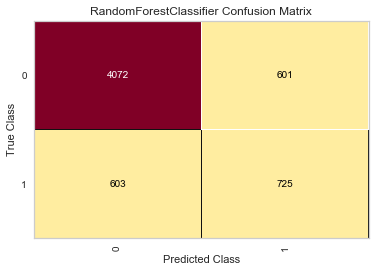

In [244]:
plot_confusion_matrix(best_ups_rf_model, X_ups, X_ups_test, y_ups, y_ups_test)

## Downsampling

## SMOTE